In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


In [319]:
class solveU:
    """Decided to make a class containing my solution for various h, just for a bit of practice."""
    def __init__(self,h=1):
        """Compute domain"""
        self.h = h
        self.N = 1/h
        self.x1 = np.arange(0,1,1/h)
        self.x2 = np.arange(0,1,1/h)
        self.x1_fe = np.arange(0,1+1/self.N,1/self.N)
        self.x2_fe = np.arange(0,1+1/self.N,1/self.N)
        
    def f(self):
        """Compute data, f(x1,x2)"""
        f1 = np.outer(np.sin(math.pi*self.x1[:-1]),np.sin(math.pi*self.x2[:-1]))
        f2 = np.outer(np.sin(math.pi*self.x1[:-1]),np.sin(2*math.pi*self.x2[:-1]))
        return f1 + f2
    
    def f_fe(self):
        """Compute data, f(x1,x2)"""
        f1 = np.outer(np.sin(math.pi*self.x1_fe),np.sin(math.pi*self.x2_fe))
        f2 = np.outer(np.sin(math.pi*self.x1_fe),np.sin(2*math.pi*self.x2_fe))
        return f1 + f2   
    
    def u(self):
        """Compute the exact solution, u(x1,x2)"""
        u1 = (1/(2*math.pi**2))*np.outer(np.sin(math.pi*self.x1),np.sin(math.pi*self.x2))
        u2 = (1/(5*math.pi**2))*np.outer(np.sin(math.pi*self.x1),np.sin(2*math.pi*self.x2))
        return (u1 + u2)[:-1,:-1]  
    
    def U_findiff(self):
        """Compute the finite diff solution, U(x1,x2)"""
        # A1d: Matrix operator for laplacian in 1D 
        A1d = (1/self.h**2)*(2*np.diag(np.ones(int(1/self.h)-1),0) 
                             - np.diag(np.ones(int(1/self.h)-2),1)  
                             - np.diag(np.ones(int(1/self.h)-2),-1))
        # A2d: Matrix operator for laplacian in 2D
        A2d = np.kron(A1d,np.eye(int(1/self.h)-1)) + np.kron(np.eye(int(1/self.h)-1),A1d)
        # U: finite diff solution
        U = np.reshape(np.linalg.inv(A2d)@self.f().flatten(),(int(1/self.h)-1,int(1/self.h)-1))
        return U
    
    def u_fe(self):
        """Compute the exact solution, u(x1,x2)"""
        u1 = (1/(2*math.pi**2))*np.outer(np.sin(math.pi*self.x1_fe),np.sin(math.pi*self.x2_fe))
        u2 = (1/(5*math.pi**2))*np.outer(np.sin(math.pi*self.x1_fe),np.sin(2*math.pi*self.x2_fe))
        return (u1 + u2)[:-1,:-1]   
    
    def U_finite_element(self):
        # h is the number of horizontal grid cells
        # Generate a mesh of T=2*(m-1)*(n-1) right triangles in unit square
        m = np.int(self.N+1)
        n = np.int(self.N+1)
        # boundary nodes, mesh spacing 1/(m-1) and 1(n-1)
        p = [self.x1_fe,self.x2_fe]
        # F is the load vector
        F = self.f_fe().flatten()
        # N by 2 matrix listing x,y coordinates of all N=mn nodes
        xv, yv = np.meshgrid(self.x1_fe, self.x2_fe, sparse=False, indexing='ij')
        # p is an N by 2 matrix listing the x,y coordinates of all N=mn nodes
        p=np.array([yv.flatten(),xv.flatten()]).T
        # node numbers of the first two triangles
        t=np.array([[0,1,m+1],[0,m+1,m]])
        # node numbers of 2(m-1) triangles in the first row
        t=np.kron(t,np.ones((m-1,1)))+np.kron(np.ones_like(t),np.arange(0,m-1)[np.newaxis].T)
        t=np.kron(t,np.ones((n-1,1)))+np.kron(np.ones_like(t),np.arange(0,n-1)[np.newaxis].T*m)
        t=t.astype(int)
        # Got all the triangles
        # the final t found above gives the node numbers of all triangles in a T by 3 matrix, (T=#triangles)
        # b is the outer nodes as top, left, right, bottom (exclusive of previously included nodes)
        b=np.concatenate((np.arange(0,m),np.arange(m,m*n,m),np.arange(2*m-1,m*n,m),np.arange(m*n-m+1,m*n-1)))
        N=len(p) # total number of nodes (p)
        T=len(t) # total number of triangles (t)
        K=np.zeros((N,N)) # zeros matrix of output K
        # For now using a test F (zero)
        #F=np.zeros((N,1))
        # for loop to integrate over each triangular element
        for i in range(0,T):
            nodes=t[i,:] # nodes of triangle T(i)
            nodesx,nodesy=np.meshgrid(nodes,nodes)
            Pi=np.concatenate((np.ones(3)[np.newaxis].T,p[nodes[:]]),axis=1) 
            tri_area=np.abs(np.linalg.det(Pi))/2
            C=np.linalg.inv(Pi)
            grad=C[1:,:]
            Ke=tri_area*grad.T@grad/(self.h**2)
            Fe=tri_area/3 # integral of phi over a triangle volume of a pyramid
            K[nodesx,nodesy] = K[(nodesx,nodesy)]+Ke
            F[nodes]=F[nodes]+Fe
        # end for loop    
        # Add Dirichlet boundary conditions
        K[b,:] = 0
        K[:,b] = 0
        # Put I into the boundary submatrix of K..?
        K[(b,b)] = 1
        F[b]=0
        Kb=K
        Fb=F
        U = np.linalg.inv(Kb)@Fb
        U_reshape = U.reshape(m,n)

        return U_reshape[:-1,:-1]

    
    def error(self):
        return self.U() - self.u()
    
    def error_fe(self):
        return self.U_finite_element() - self.u_fe()        

In [320]:
U10 = solveU(1/10)
U20 = solveU(1/20)



# Plots of h=1/10

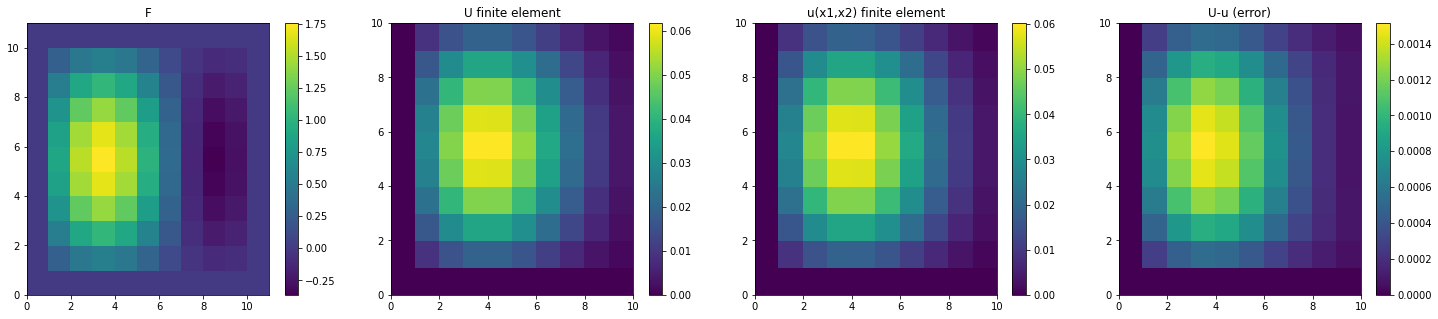

In [321]:
fig = plt.figure(figsize=(25,5))
gs = gridspec.GridSpec(nrows=1,ncols=4)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2])
ax3 = fig.add_subplot(gs[3])

im0 = ax0.pcolor(U10.f_fe())
ax0.set_title("F")
fig.colorbar(im0, ax=ax0)

im1 = ax1.pcolor(U10.U_finite_element())
ax1.set_title("U finite element")
fig.colorbar(im1, ax=ax1)

im2 = ax2.pcolor(U10.u_fe())
ax2.set_title("u(x1,x2) finite element")
fig.colorbar(im2, ax=ax2)

im3 = ax3.pcolor(U10.U_finite_element()- U10.u_fe())
ax3.set_title("U-u (error)")
fig.colorbar(im3, ax=ax3)

plt.show()
plt.close()

# Plots of h=1/20

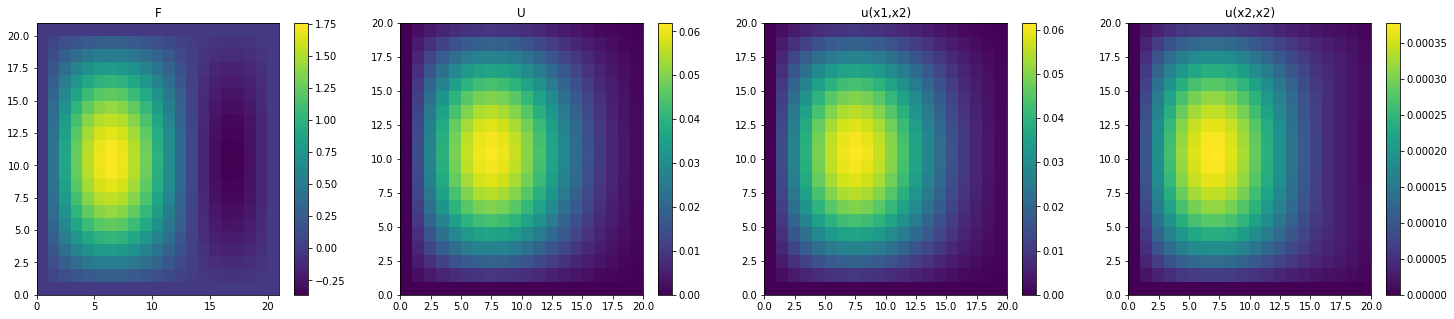

In [322]:
fig = plt.figure(figsize=(25,5))
gs = gridspec.GridSpec(nrows=1,ncols=4)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2])
ax3 = fig.add_subplot(gs[3])

im0 = ax0.pcolor(U20.f_fe())
ax0.set_title("F")
fig.colorbar(im0, ax=ax0)

im1 = ax1.pcolor(U20.U_finite_element())
ax1.set_title("U")
fig.colorbar(im1, ax=ax1)

im2 = ax2.pcolor(U20.u_fe())
ax2.set_title("u(x1,x2)")
fig.colorbar(im2, ax=ax2)

im3 = ax3.pcolor(U20.U_finite_element() - U20.u_fe())
ax3.set_title("U-u (error)")
fig.colorbar(im3, ax=ax3)

plt.show()
plt.close()

# Error for h=1/10 and h=1/20, respectively

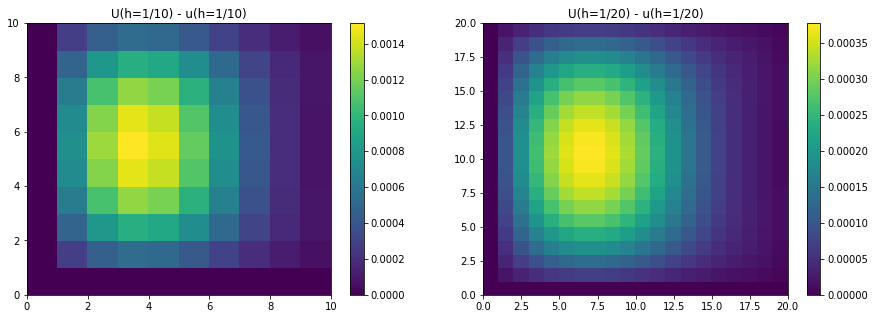

Error at (0.5,0.5) for h=1/10:  0.0011497152704995212
Error at (0.5,0.5) for h=1/20:  0.0002881120761609249
Error at (0.5,0.5) w/ Richardson approx:  -0.0005734911181776714


In [327]:
## Plots ##

fig = plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(nrows=1,ncols=2)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

im0 = ax0.pcolor(U10.U_finite_element() - U10.u_fe())
ax0.set_title("U(h=1/10) - u(h=1/10)")
fig.colorbar(im0, ax=ax0)

im1 = ax1.pcolor(U20.U_finite_element() - U20.u_fe())
ax1.set_title("U(h=1/20) - u(h=1/20)")
fig.colorbar(im1, ax=ax1)

plt.show()
plt.close()

## Error ##
error10 = U10.error_fe()
error20 = U20.error_fe()
richardson_error = (2*U20.U_finite_element()[10,10]- U10.U_finite_element()[5,5]) - U20.u_fe()[10,10]
print("Error at (0.5,0.5) for h=1/10: ", error10[5,5])
print("Error at (0.5,0.5) for h=1/20: ", error20[10,10])
print("Error at (0.5,0.5) w/ Richardson approx: ",richardson_error)

# Take a look to see when I start getting better approximations

In [328]:
U_dict = {}
for i in range(10,91,10):
    h = 1/i
    U_dict["U"+str(i)] = solveU(h)
    print("Error at (0.5,0.5) for h=1/"+str(i)+": ", U_dict["U"+str(i)].error_fe()[int(i/2),int(i/2)])


Error at (0.5,0.5) for h=1/10:  0.0011497152704995212
Error at (0.5,0.5) for h=1/20:  0.0002881120761609249


LinAlgError: Singular matrix

In [330]:
for i in range(20,91,10):
    U2 = U_dict["U"+str(i)]
    U1 = U_dict["U"+str(i-10)]
    richardson_error = (2*U2.U_finite_element()[int(i/2),int(i/2)]- U1.U_finite_element()[int((i-10)/2),int((i-10)/2)]) - U2.u_fe()[int(i/2),int(i/2)]  
    print("Richardson Error for Uh"+str(i)+" - Uh"+str(i-10)+": ", richardson_error)

Richardson Error for Uh20 - Uh10:  -0.0005734911181776714


LinAlgError: Singular matrix